# PROYECTO 3 FILTRADO DE SEÑALES ECG

Daniel Palacio Alvarez

Alejandro Agudelo Tamayo

Federico Ocampo Quiceno

---

In [1]:
#Librerias
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import neurokit2 as nk
import seaborn as sns
import random

from skimage.restoration import denoise_nl_means
import statsmodels.api as sm
from statsmodels.robust import mad
import pywt
from scipy.signal import butter, filtfilt, detrend, welch
from statsmodels.nonparametric.smoothers_lowess import lowess

In [2]:
datos_filtrados = pd.read_csv("datos_filtrados.csv")
nombres_filtrados = datos_filtrados['FileName'].tolist()
fs=500 # Frecuencia de muestreo en Hz
datos_filtrados.head()

,FileName,Rhythm,Beat,PatientAge,Gender,VentricularRate,AtrialRate,QRSDuration,QTInterval,QTCorrected,RAxis,TAxis,QRSCount,QOnset,QOffset,TOffset
0,MUSE_20180113_171327_27000,AFIB,RBBB TWC,85,MALE,117,234,114,356,496,81,-27,19,208,265,386
1,MUSE_20180112_073319_29000,SB,TWC,59,FEMALE,52,52,92,432,401,76,42,8,215,261,431
2,MUSE_20180113_121940_44000,SB,NONE,66,MALE,53,53,96,456,427,34,3,9,219,267,447
3,MUSE_20180112_122850_57000,AF,STDD STTC,73,FEMALE,162,162,114,252,413,68,-40,26,228,285,354
4,MUSE_20180112_120347_79000,SB,NONE,46,FEMALE,57,57,70,404,393,38,24,9,225,260,427


---
## Implementación Robust LOESS y Non Local Means

In [ ]:
sigma_est = np.std(ecg)  # o usar MAD como en el artículo
ecg_nlm = denoise_nl_means(ecg, h=1.5 * sigma_est, fast_mode=True,
                           patch_size=5, patch_distance=10, multichannel=False)

In [ ]:
x = np.linspace(0, 10, len(ecg))
loess_result = sm.nonparametric.lowess(ecg, x, frac=0.05, it=3)
ecg_loess = loess_result[:, 1]  # señal suavizada

## Adaptación filtro Wavelet

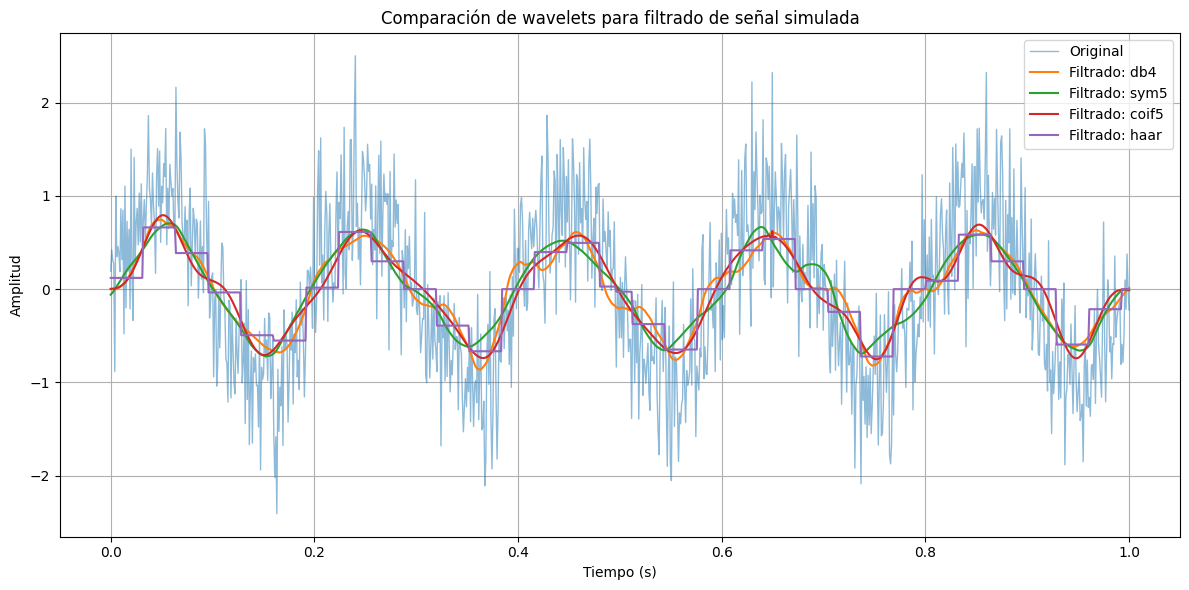

In [ ]:
# --------------------------------------------
# Función para estimar el nivel de ruido
# usando la desviación absoluta de la mediana (MAD)
# --------------------------------------------
def wnoisest(coeff):
    stdc = np.zeros((len(coeff), 1))
    for i in range(len(coeff)):
        stdc[i] = np.median(np.abs(coeff[i])) / 0.6745
    return stdc

# --------------------------------------------
# Función de filtrado con Transformada Wavelet Discreta
# --------------------------------------------
def wavelet_filter(signal, wavelet_name='db4', level=5):
    """
    Aplica filtrado de ruido mediante DWT con umbralización suave.

    Parámetros:
    - signal: ndarray, señal 1D (por ejemplo, ECG)
    - wavelet_name: str, nombre de la wavelet ('db4', 'sym5', etc.)
    - level: int, nivel de descomposición

    Retorna:
    - filtered_signal: ndarray, señal reconstruida y filtrada
    """
    # Descomposición multiresolución
    coeffs = pywt.wavedec(signal, wavelet_name, level=level)

    # Estimar ruido en el último nivel de detalle
    sigma = mad(coeffs[-1])
    uthresh = sigma * np.sqrt(2 * np.log(len(signal)))

    # Aplicar umbralización suave a los coeficientes
    coeffs_thresh = [pywt.threshold(c, value=uthresh, mode='soft') for c in coeffs]

    # Reconstrucción de la señal
    filtered_signal = pywt.waverec(coeffs_thresh, wavelet_name)

    return filtered_signal

# --------------------------------------------
# Ejemplo de uso con señal simulada
# --------------------------------------------

# Crear señal de prueba con ruido
t = np.linspace(0, 1, 1000)
signal = np.sin(2 * np.pi * 5 * t) + 0.5 * np.random.randn(1000)

# Lista de wavelets a comparar
wavelets = ['db4', 'sym5', 'coif5', 'haar']

# Graficar señal original y señales filtradas
plt.figure(figsize=(12, 6))
plt.plot(t, signal, label='Original', alpha=0.5, linewidth=1)

for w in wavelets:
    filtered = wavelet_filter(signal, wavelet_name=w)
    plt.plot(t, filtered, label=f'Filtrado: {w}')

plt.title("Comparación de wavelets para filtrado de señal simulada")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

---

## IMPLEMENTACIÓN DE FLUJOS DE FILTRADO

### Flujo 1 

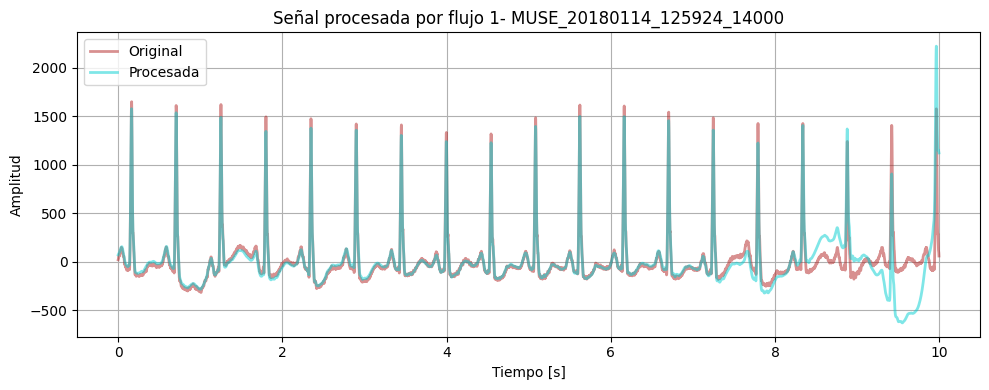

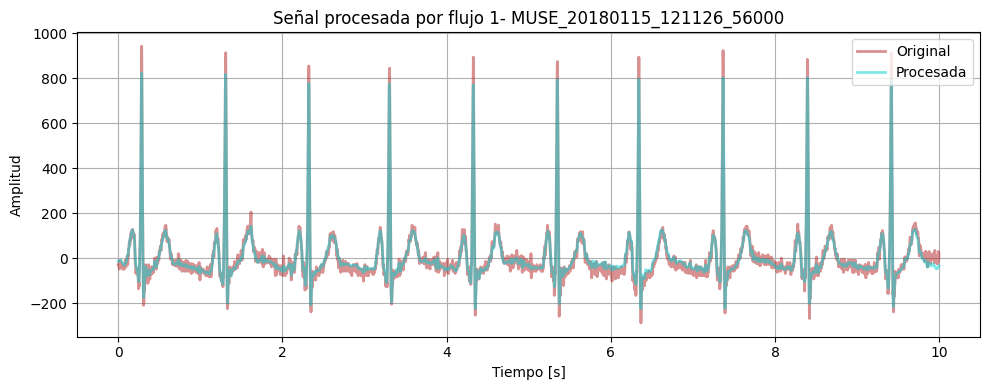

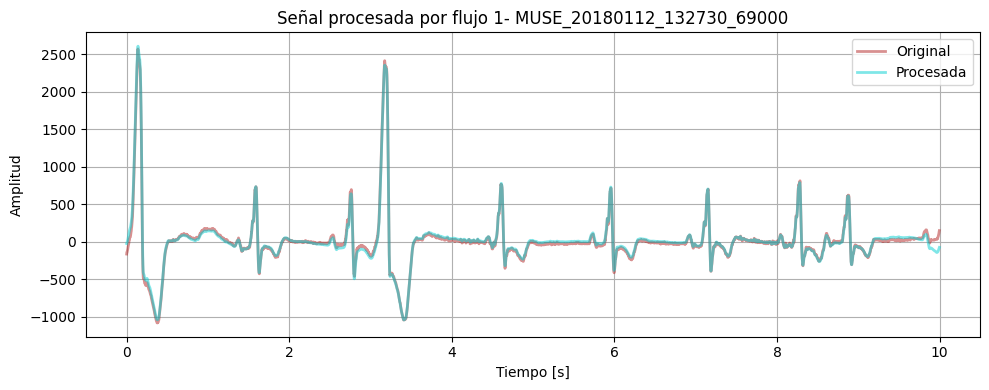

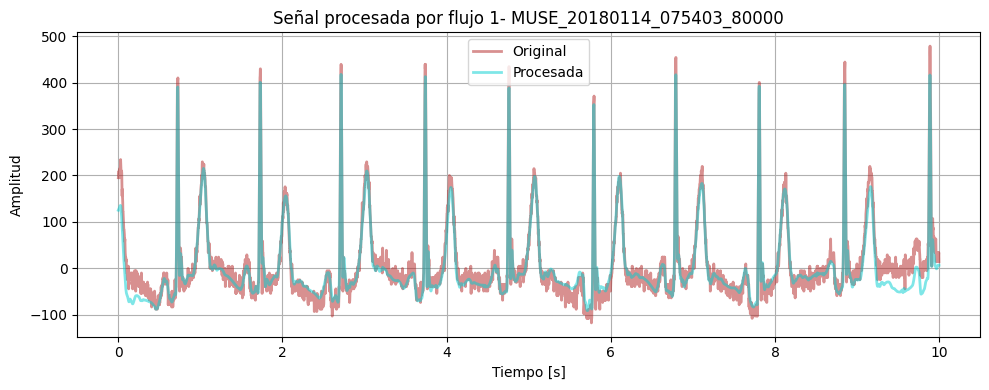

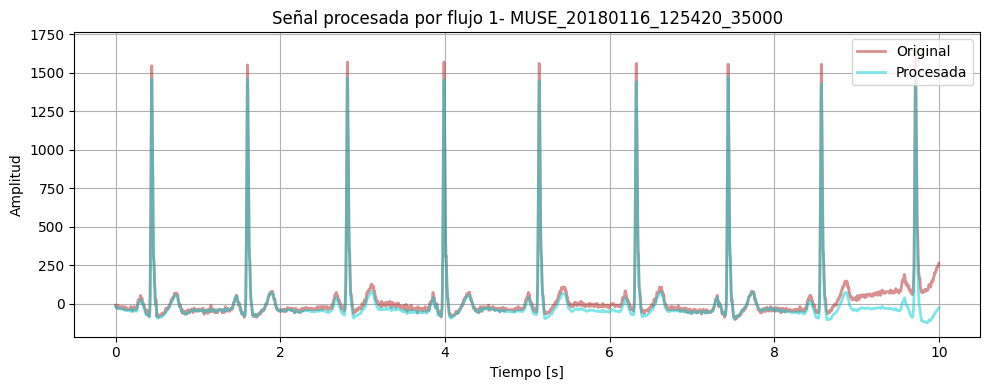

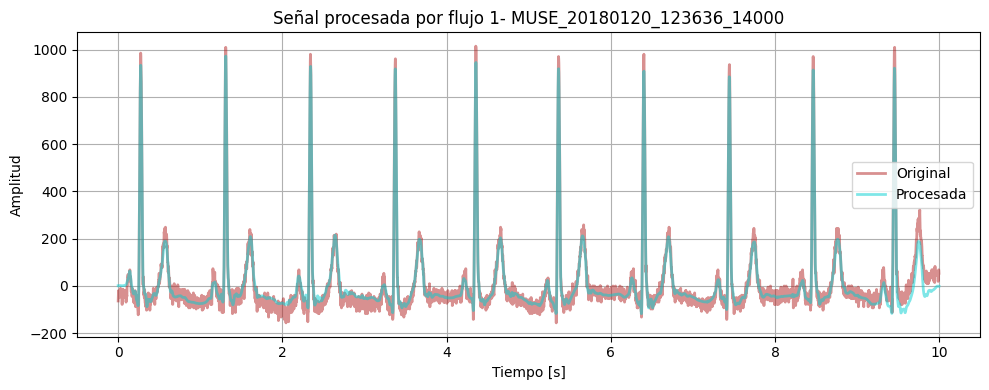

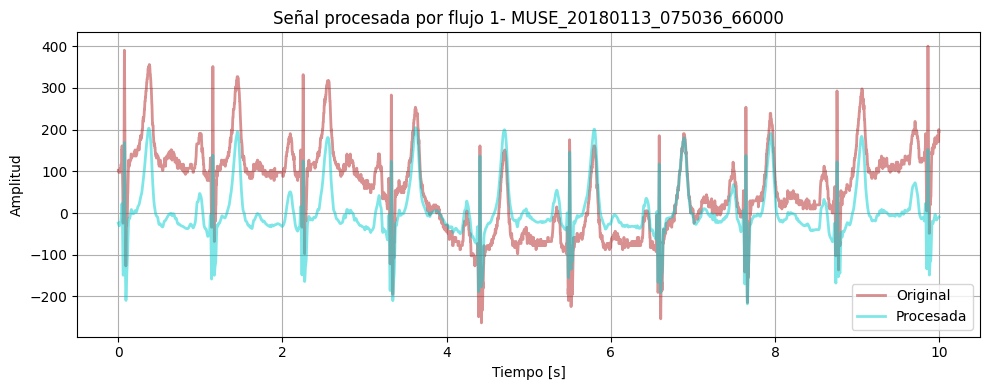

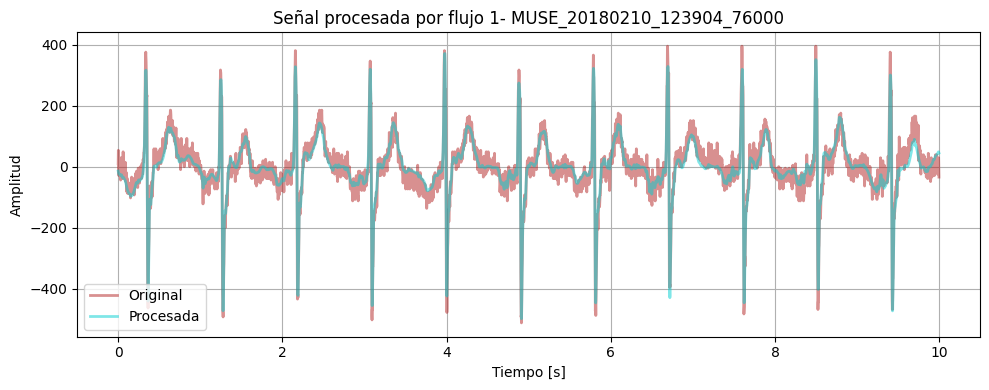

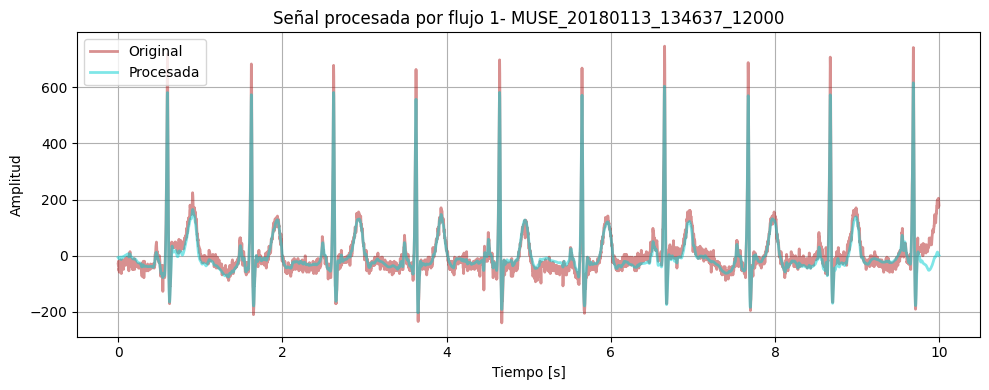

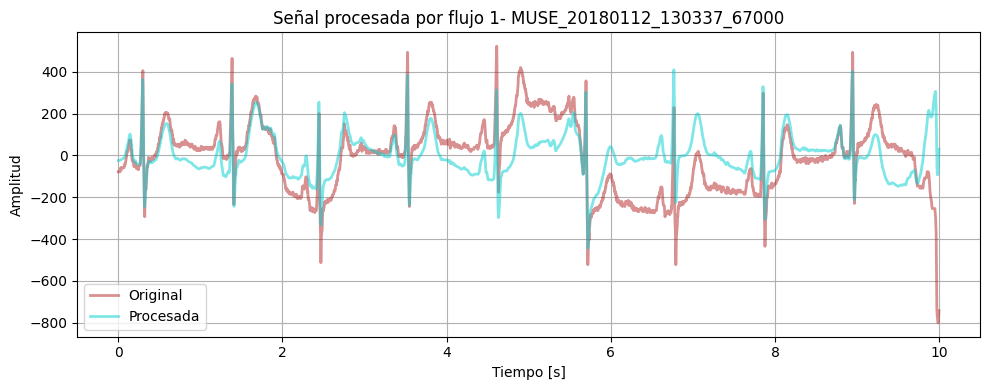

In [45]:
# ----------------------------
# PASO 1: FILTRO PASAALTAS IIR
# ----------------------------
def highpass_filter(signal, fs, cutoff=0.5, order=4):
    """
    Filtro pasaaltas Butterworth IIR para eliminar desplazamiento de línea base.
    """
    nyq = 0.5 * fs
    norm_cutoff = cutoff / nyq
    b, a = butter(order, norm_cutoff, btype='high', analog=False)
    filtered = filtfilt(b, a, signal)
    return filtered

# ----------------------------
# PASO 2: FILTRO WAVELET
# ----------------------------
def wavelet_filter(signal, wavelet_name='db4', level=5):
    """
    Filtro por transformada wavelet discreta (DWT).
    """
    import pywt
    from statsmodels.robust import mad

    coeffs = pywt.wavedec(signal, wavelet_name, level=level)
    sigma = mad(coeffs[-1])
    uthresh = sigma * np.sqrt(2 * np.log(len(signal)))
    coeffs_thresh = [pywt.threshold(c, value=uthresh, mode='soft') for c in coeffs]
    filtered_signal = pywt.waverec(coeffs_thresh, wavelet_name)
    return filtered_signal

# ----------------------------
# PASO 3: FILTRO PASABAJO IIR
# ----------------------------
def lowpass_filter(signal, fs, cutoff=50, order=4):
    """
    Filtro pasabajo Butterworth IIR para eliminar componentes de alta frecuencia.
    """
    nyq = 0.5 * fs
    norm_cutoff = cutoff / nyq
    b, a = butter(order, norm_cutoff, btype='low', analog=False)
    filtered = filtfilt(b, a, signal)
    return filtered

# ----------------------------
# FLUJO COMPLETO
# ----------------------------
def flujo_1(signal, fs, wavelet='db4'):
    """
    Aplica el Flujo 1 completo a una señal ECG.
    """
    sig1 = highpass_filter(signal, fs=fs, cutoff=0.5)
    sig2 = wavelet_filter(sig1, wavelet_name=wavelet)
    sig3 = lowpass_filter(sig2, fs=fs, cutoff=50)
    return sig3

# ----------------------------
# PROCESAMIENTO DE ARCHIVOS ECG
# ----------------------------
carpeta = "D:\Documentos\BIOSEÑALES\Proyecto3\ECGData/"
ruta = os.path.abspath(carpeta)
fs = 500  # frecuencia de muestreo
wavelet = 'db4'

random.seed(42) #Semilla fija para reproducir

nombres_seleccionados = random.sample(nombres_filtrados, 10) # 10 archivos ECG aleatorios

for nombre in nombres_seleccionados:
    archivo_csv = os.path.join(ruta, f"{nombre}.csv")
    
    if not os.path.exists(archivo_csv):
        print(f"Archivo no encontrado: {archivo_csv}")
        continue

    try:
        senal = pd.read_csv(archivo_csv, delimiter=',')
        signal_ekg = senal['II'].values

        # Aplicar flujo de procesamiento
        signal_procesada = flujo_1(signal_ekg, fs=fs, wavelet=wavelet)

        # Graficar señal original y procesada (opcional)
        tiempo = np.arange(len(signal_ekg)) / fs
        plt.figure(figsize=(10, 4))
        plt.plot(tiempo, signal_ekg, label='Original', alpha=0.5, color='firebrick', linewidth=2)
        plt.plot(tiempo, signal_procesada, label='Procesada', color='darkturquoise', alpha=0.5, linewidth=2)
        plt.title(f"Señal procesada por flujo 1- {nombre}")
        plt.xlabel("Tiempo [s]")
        plt.ylabel("Amplitud")
        plt.legend()
        plt.tight_layout()
        plt.grid(True)
        plt.show()

    except Exception as e:
        print(f"Error procesando {nombre}: {e}")

### Flujo 2

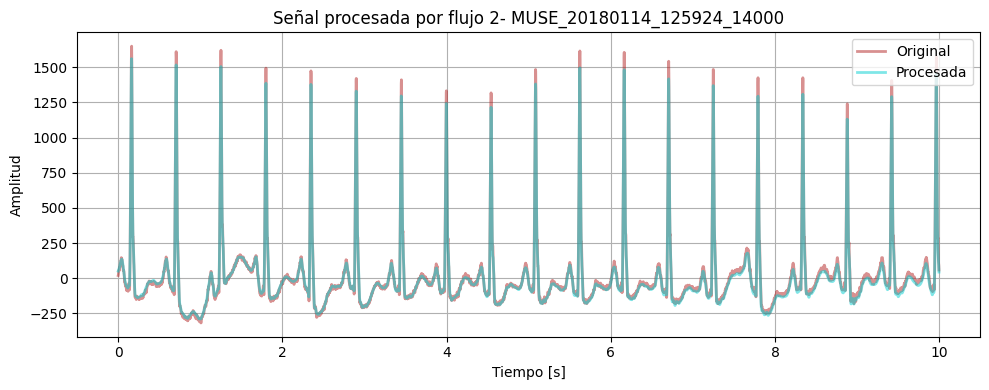

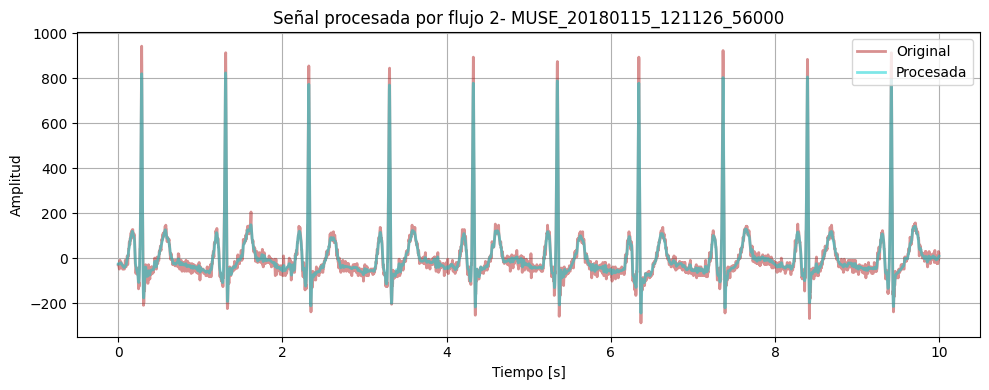

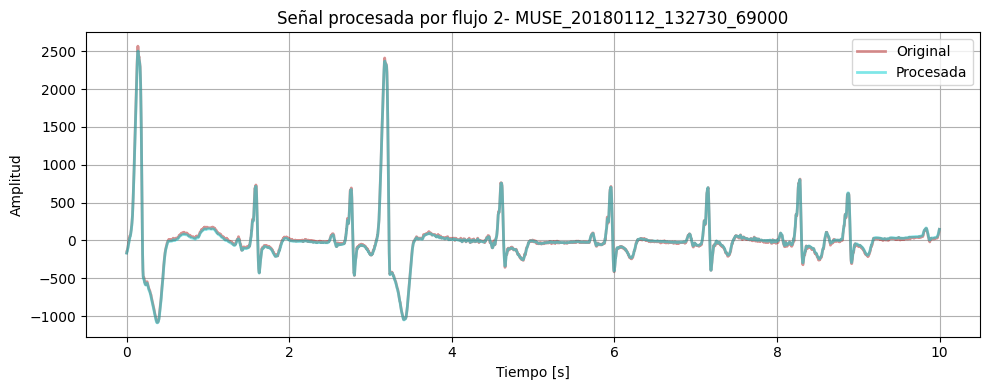

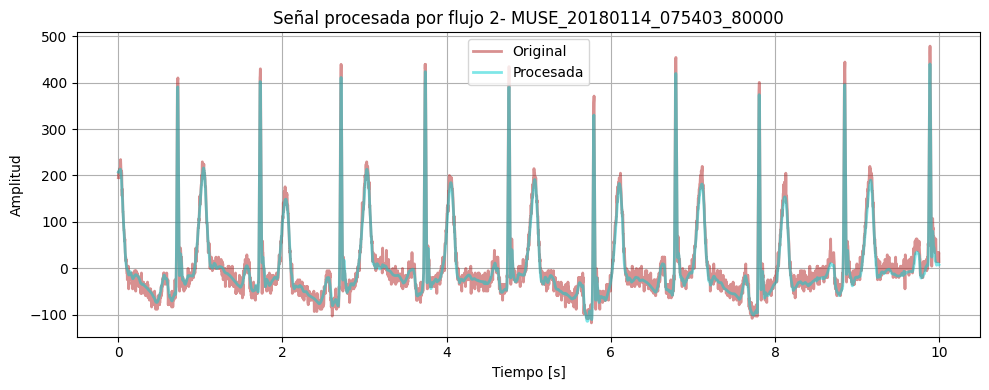

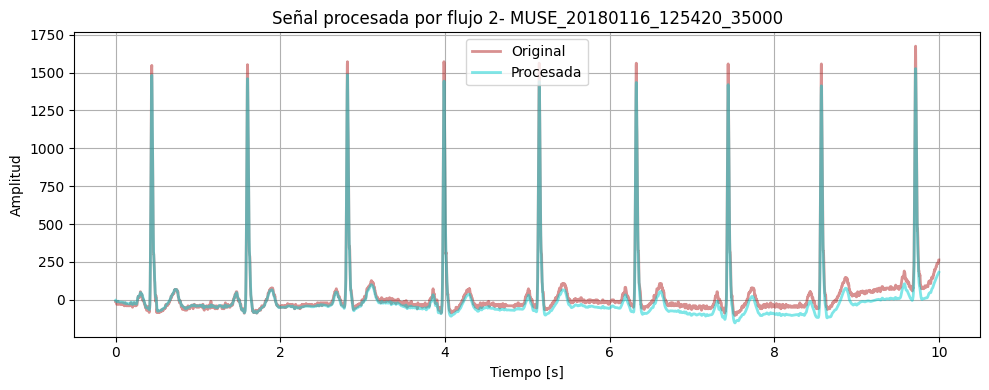

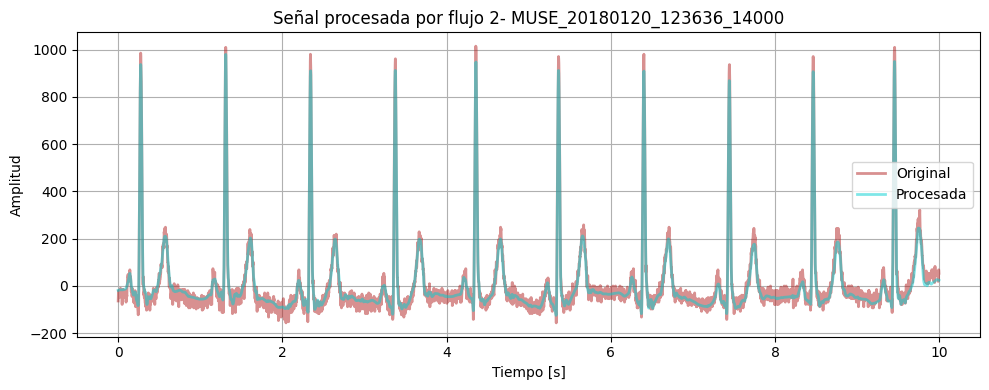

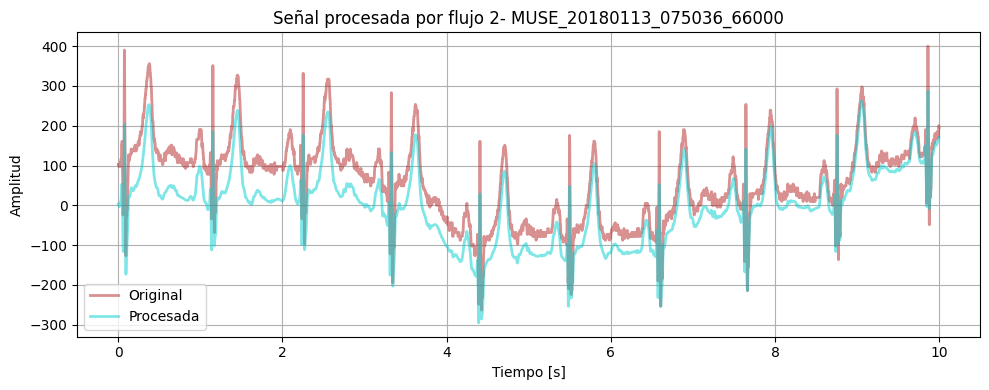

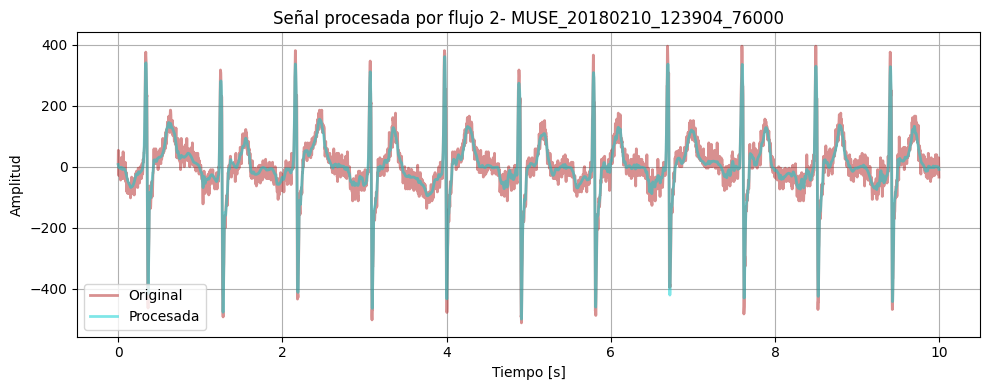

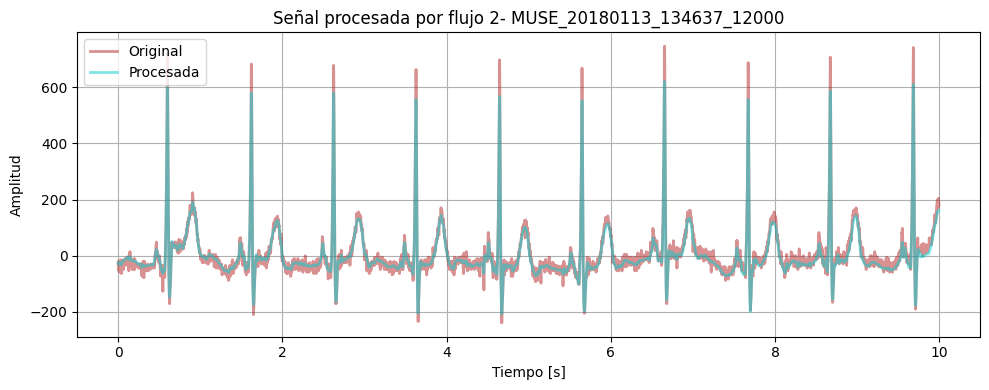

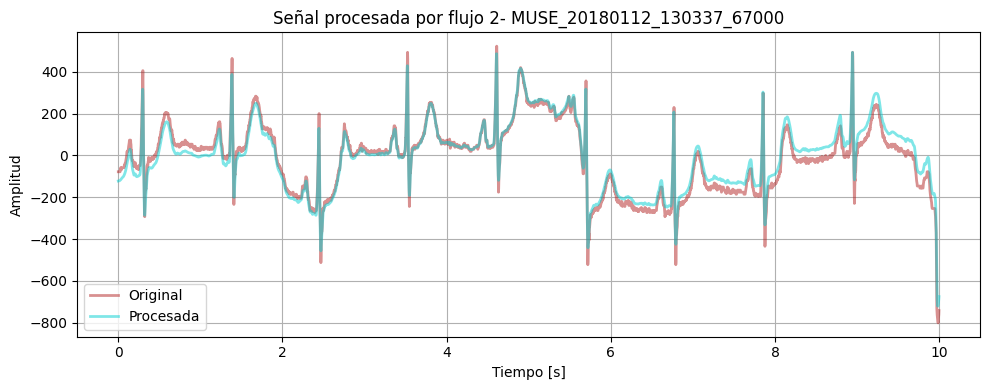

In [3]:
# ----------------------------
# PASO 1: DETREND
# ----------------------------
def remove_trend(signal):
    """
    Elimina la tendencia lineal global de la señal.
    """
    return detrend(signal)

# ----------------------------
# PASO 2: FILTRO WAVELET
# (ya definido en flujo 1, se reutiliza)
# ----------------------------
def wavelet_filter(signal, wavelet_name='db4', level=5):

    coeffs = pywt.wavedec(signal, wavelet_name, level=level)
    sigma = mad(coeffs[-1])
    uthresh = sigma * np.sqrt(2 * np.log(len(signal)))
    coeffs_thresh = [pywt.threshold(c, value=uthresh, mode='soft') for c in coeffs]
    return pywt.waverec(coeffs_thresh, wavelet_name)

# ----------------------------
# PASO 3: FILTRO PASABAJO
# ----------------------------
def lowpass_filter(signal, fs, cutoff=50, order=4):
    nyq = 0.5 * fs
    norm_cutoff = cutoff / nyq
    b, a = butter(order, norm_cutoff, btype='low', analog=False)
    return filtfilt(b, a, signal)

# ----------------------------
# FLUJO COMPLETO
# ----------------------------
def flujo_2(signal, fs, wavelet='db4'):
    sig1 = remove_trend(signal)
    sig2 = wavelet_filter(sig1, wavelet_name=wavelet)
    sig3 = lowpass_filter(sig2, fs=fs, cutoff=50)
    return sig3

# ----------------------------
# PROCESAMIENTO DE ARCHIVOS ECG
# ----------------------------
carpeta = "D:\Documentos\BIOSEÑALES\Proyecto3\ECGData/"
ruta = os.path.abspath(carpeta)
fs = 500  # frecuencia de muestreo
wavelet = 'db4'

random.seed(42) #Semilla fija para reproducir

nombres_seleccionados = random.sample(nombres_filtrados, 10) # 10 archivos ECG aleatorios

for nombre in nombres_seleccionados:
    archivo_csv = os.path.join(ruta, f"{nombre}.csv")
    
    if not os.path.exists(archivo_csv):
        print(f"Archivo no encontrado: {archivo_csv}")
        continue

    try:
        senal = pd.read_csv(archivo_csv, delimiter=',')
        signal_ekg = senal['II'].values

        # Aplicar flujo de procesamiento
        signal_procesada = flujo_2(signal_ekg, fs=fs, wavelet=wavelet)

        # Graficar señal original y procesada (opcional)
        tiempo = np.arange(len(signal_ekg)) / fs
        plt.figure(figsize=(10, 4))
        plt.plot(tiempo, signal_ekg, label='Original', alpha=0.5, color='firebrick', linewidth=2)
        plt.plot(tiempo, signal_procesada, label='Procesada', color='darkturquoise', alpha=0.5, linewidth=2)
        plt.title(f"Señal procesada por flujo 2- {nombre}")
        plt.xlabel("Tiempo [s]")
        plt.ylabel("Amplitud")
        plt.legend()
        plt.tight_layout()
        plt.grid(True)
        plt.show()

    except Exception as e:
        print(f"Error procesando {nombre}: {e}")

### Flujo 3

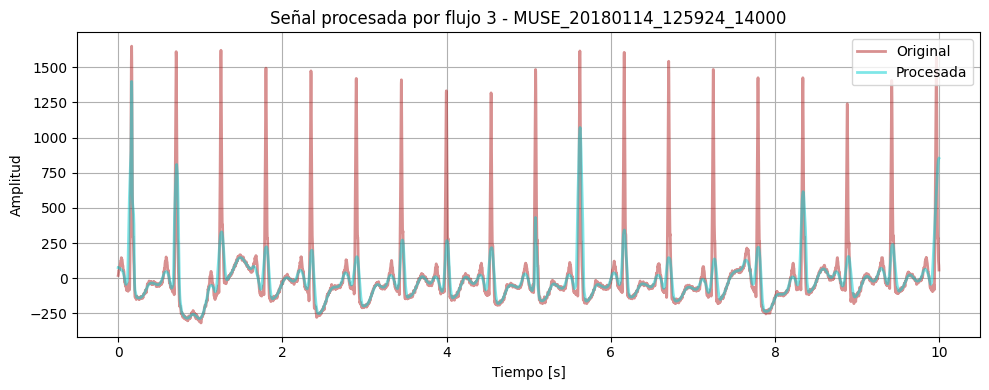

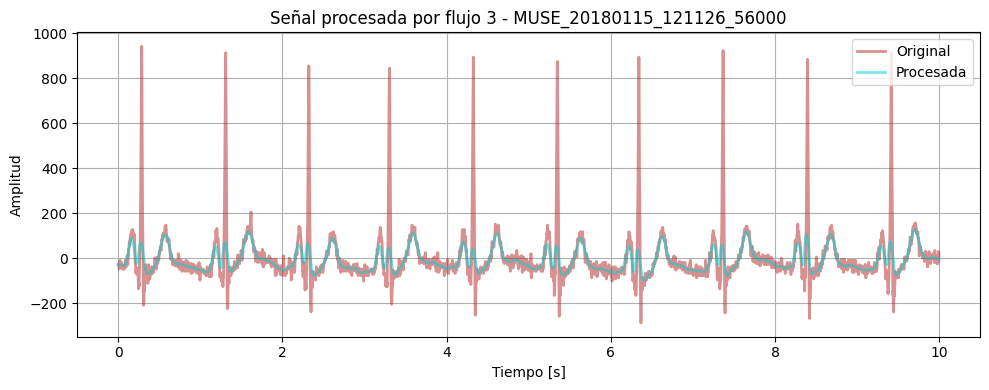

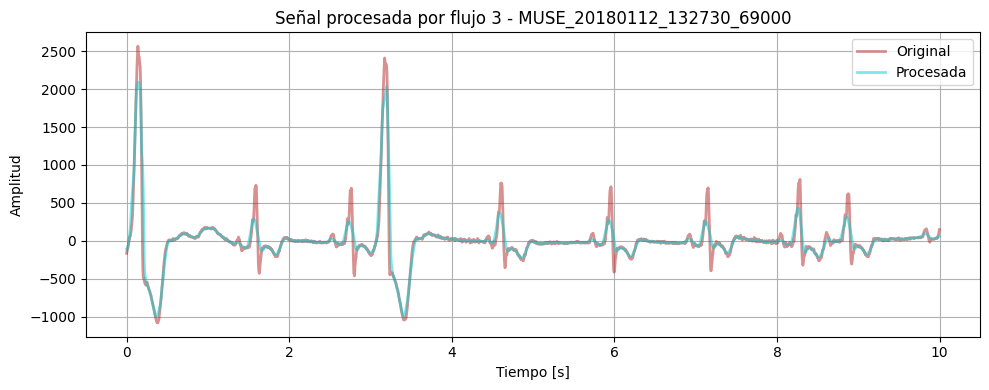

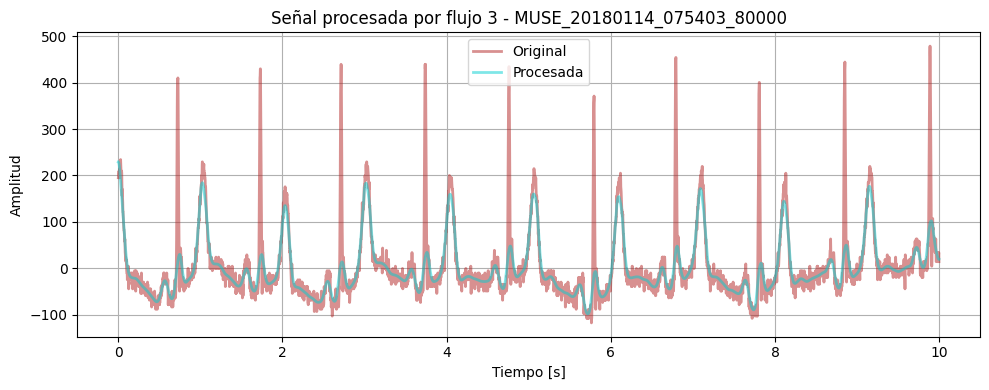

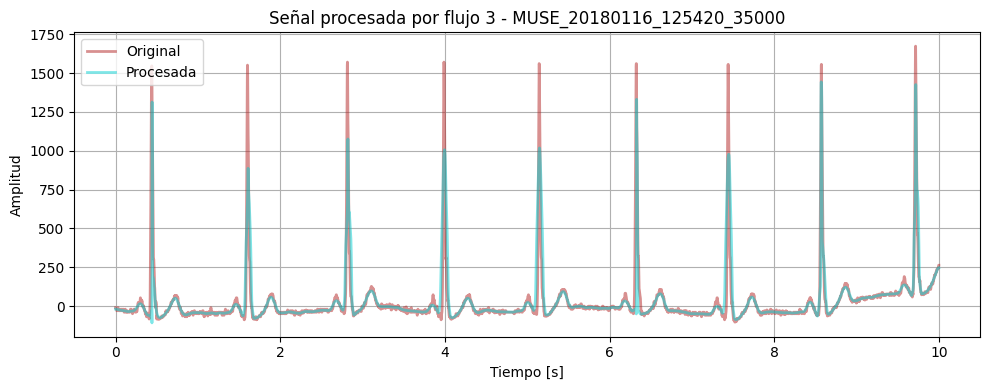

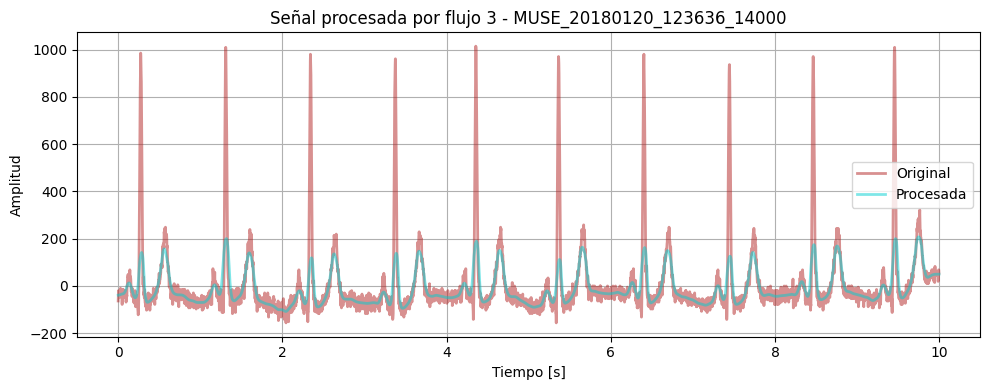

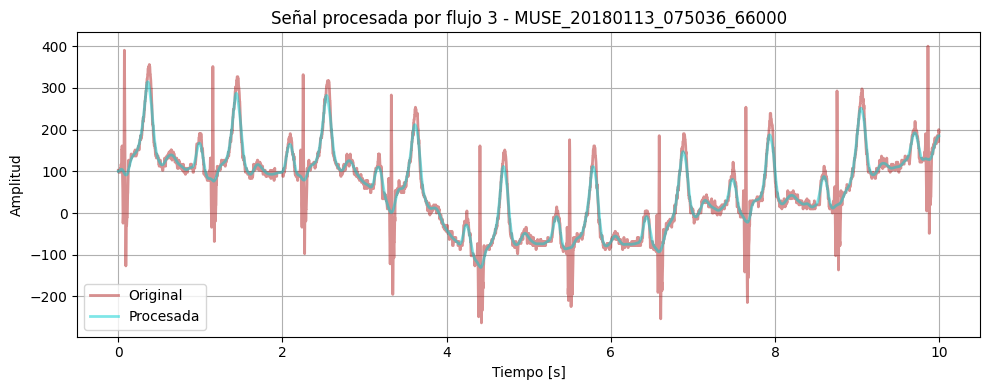

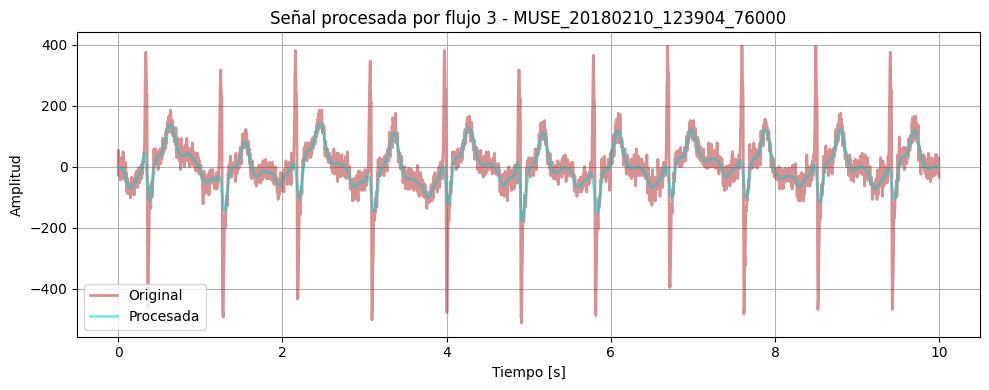

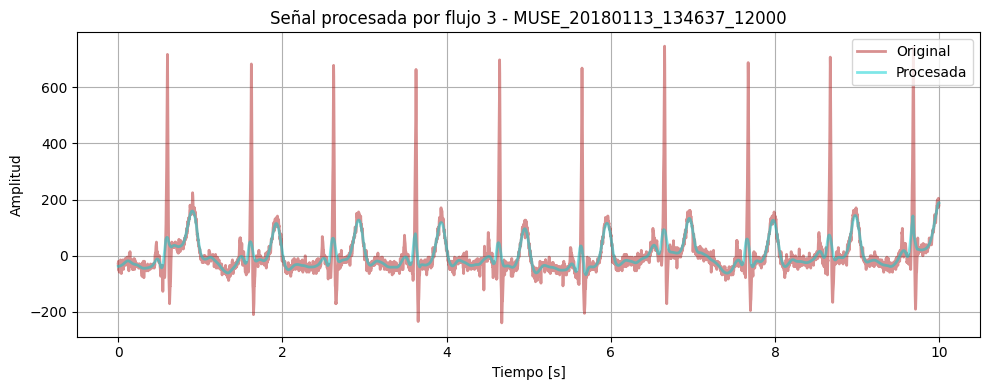

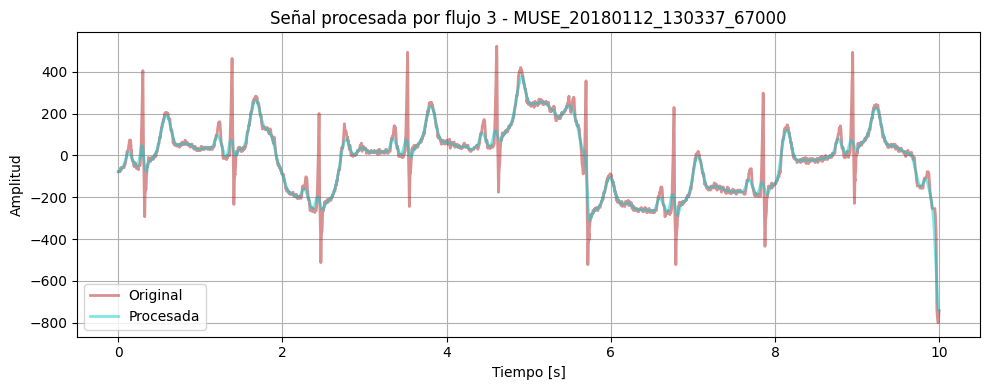

In [47]:
# ----------------------------
# PASO 1: FILTRO PASABAJAS IIR
# ----------------------------
def lowpass_filter(signal, fs, cutoff=50, order=4):
    nyq = 0.5 * fs
    norm_cutoff = cutoff / nyq
    b, a = butter(order, norm_cutoff, btype='low', analog=False)
    return filtfilt(b, a, signal)

# ----------------------------
# PASO 2: FILTRADO LOESS
# ----------------------------
def loess_filter(signal, frac=0.01, it=3):
    """
    Suavizado LOESS robusto (polinomio local). frac es el tamaño de ventana relativo.
    """
    x = np.arange(len(signal))
    loess_result = lowess(signal, x, frac=frac, it=it, return_sorted=False)
    return loess_result

# ----------------------------
# PASO 3: NON LOCAL MEANS
# ----------------------------
def nlm_filter(signal):
    """
    Aplica Non Local Means (NLM) a señal 1D convirtiéndola en una imagen 2D (fila única).
    """

    # Convertir a formato 2D (1, N) para evitar error
    signal_2d = signal[np.newaxis, :]
    
    sigma_est = np.std(signal)
    denoised_2d = denoise_nl_means(signal_2d,
                h=1.5 * sigma_est,
                fast_mode=True,
                patch_size=5,
                patch_distance=10,
                channel_axis=None)
    
    # Volver a 1D
    denoised_1d = denoised_2d.flatten()
    return denoised_1d

# ----------------------------
# FLUJO COMPLETO
# ----------------------------
def flujo_3(signal, fs):
    sig1 = lowpass_filter(signal, fs=fs, cutoff=50)
    sig2 = loess_filter(sig1, frac=0.01, it=3)
    sig3 = nlm_filter(sig2)
    return sig3

# ----------------------------
# PROCESAMIENTO DE ARCHIVOS ECG
# ----------------------------
carpeta = "D:\Documentos\BIOSEÑALES\Proyecto3\ECGData/"
ruta = os.path.abspath(carpeta)
fs = 500  # frecuencia de muestreo

random.seed(42) #Semilla fija para reproducir

nombres_seleccionados = random.sample(nombres_filtrados, 10) # 10 archivos ECG aleatorios

for nombre in nombres_seleccionados:
    archivo_csv = os.path.join(ruta, f"{nombre}.csv")
    
    if not os.path.exists(archivo_csv):
        print(f"Archivo no encontrado: {archivo_csv}")
        continue

    try:
        senal = pd.read_csv(archivo_csv, delimiter=',')
        signal_ekg = senal['II'].values

        # Aplicar flujo de procesamiento
        signal_procesada = flujo_3(signal_ekg, fs=fs)

        # Graficar señal original y procesada (opcional)
        tiempo = np.arange(len(signal_ekg)) / fs
        plt.figure(figsize=(10, 4))
        plt.plot(tiempo, signal_ekg, label='Original', alpha=0.5, color='firebrick', linewidth=2)
        plt.plot(tiempo, signal_procesada, label='Procesada', color='darkturquoise', alpha=0.5, linewidth=2)
        plt.title(f"Señal procesada por flujo 3 - {nombre}")
        plt.xlabel("Tiempo [s]")
        plt.ylabel("Amplitud")
        plt.legend()
        plt.tight_layout()
        plt.grid(True)
        plt.show()

    except Exception as e:
        print(f"Error procesando {nombre}: {e}")

### Procesamiento de toda la base de datos ECGData

In [4]:
def frecuencia_maxima_potencia(signal, fs, nperseg=1024, plot=False):
    """
    Estima la frecuencia con máxima potencia usando el método de Welch.

    Parámetros:
    - signal: array 1D, señal ECG procesada
    - fs: frecuencia de muestreo en Hz
    - nperseg: número de puntos por segmento para Welch (por defecto: 1024)
    - plot: si True, grafica la densidad espectral

    Retorna:
    - f_max: frecuencia con mayor potencia (Hz)
    - f: vector de frecuencias
    - Pxx: densidad espectral de potencia
    """
    f, Pxx = welch(signal, fs=fs, nperseg=nperseg)

    idx_max = np.argmax(Pxx)
    f_max = f[idx_max]

    if plot:
        plt.figure(figsize=(8, 4))
        plt.semilogy(f, Pxx)
        plt.axvline(f_max, color='red', linestyle='--', label=f'Frec. máxima: {f_max:.2f} Hz')
        plt.title("Densidad espectral de potencia (Welch)")
        plt.xlabel("Frecuencia (Hz)")
        plt.ylabel("Densidad de potencia")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    return f_max, f, Pxx


In [5]:
# ----------------------------
# PROCESAMIENTO DE ARCHIVOS ECG
# ----------------------------
carpeta = "D:\Documentos\BIOSEÑALES\Proyecto3\ECGData/"
ruta = os.path.abspath(carpeta)
fs = 500  # frecuencia de muestreo
wavelet = 'db4'

#Lista para almacenar la data
lista_flujo2 = []

for nombre in nombres_filtrados:
    archivo_csv = os.path.join(ruta, f"{nombre}.csv")
    
    if not os.path.exists(archivo_csv):
        print(f"Archivo no encontrado: {archivo_csv}")
        continue

    try:
        senal = pd.read_csv(archivo_csv, delimiter=',')
        signal_ekg = senal['II'].values

        # Aplicar flujo de procesamiento
        signal_procesada = flujo_2(signal_ekg, fs=fs, wavelet=wavelet)
        frec_max_pot, f, dens_esp_pot = frecuencia_maxima_potencia(signal_procesada, fs=500, nperseg=1024, plot=False)

        # Obtener clase de arritmia desde el DataFrame original
        arritmia = datos_filtrados.loc[datos_filtrados['FileName'] == nombre, 'Rhythm'].values[0]

        # Guardar 
        lista_flujo2.append({
            'Registro': nombre,
            'Arritmia': arritmia,
            'fMP': frec_max_pot
        })

    except Exception as e:
        print(f"Error procesando {nombre}: {e}")





In [6]:
df_proyecto3 = pd.DataFrame(lista_flujo2)
df_proyecto3.head()

,Registro,Arritmia,fMP
0,MUSE_20180113_171327_27000,AFIB,0.488281
1,MUSE_20180112_073319_29000,SB,0.976562
2,MUSE_20180113_121940_44000,SB,3.417969
3,MUSE_20180112_122850_57000,AF,5.371094
4,MUSE_20180112_120347_79000,SB,0.976562


In [7]:
# ----------------------------
# PROCESAMIENTO DE ARCHIVOS ECG
# ----------------------------
carpeta = "D:/Documentos/BIOSEÑALES/Proyecto3/ECGDataDenoised/"
ruta = os.path.abspath(carpeta)
fs = 500  # frecuencia de muestreo

#Lista para almacenar la data
lista_ecgfiltrada = []

for nombre in nombres_filtrados:
    archivo_csv = os.path.join(ruta, f"{nombre}.csv")
    
    if not os.path.exists(archivo_csv):
        print(f"Archivo no encontrado: {archivo_csv}")
        continue

    try:
        senal = pd.read_csv(archivo_csv, delimiter=',',
                            names=['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'])
        signal_ekg = senal['II'].values

        frec_max_pot, f, dens_esp_pot = frecuencia_maxima_potencia(signal_ekg, fs=500, nperseg=1024, plot=False)

        # Obtener clase de arritmia desde el DataFrame original
        arritmia = datos_filtrados.loc[datos_filtrados['FileName'] == nombre, 'Rhythm'].values[0]

        # Guardar 
        lista_ecgfiltrada.append({
            'Registro': nombre,
            'Arritmia': arritmia,
            'fMP': frec_max_pot
        })

    except Exception as e:
        print(f"Error procesando {nombre}: {e}")

In [8]:
df_filtrada = pd.DataFrame(lista_ecgfiltrada)
df_filtrada.head()

,Registro,Arritmia,fMP
0,MUSE_20180113_171327_27000,AFIB,13.183594
1,MUSE_20180112_073319_29000,SB,3.417969
2,MUSE_20180113_121940_44000,SB,3.417969
3,MUSE_20180112_122850_57000,AF,5.371094
4,MUSE_20180112_120347_79000,SB,3.906250


## Estadistica descriptiva

In [12]:
df_proyecto3.groupby('Arritmia')['fMP'].describe()

,count,mean,std,min,25%,50%,75%,max
Arritmia,,,,,,,,
AF,406.0,3.825672,3.233975,0.488281,2.441406,3.417969,4.882812,49.804688
AFIB,1713.0,3.008075,2.586135,0.488281,1.464844,2.929688,3.906250,49.804688
SB,3473.0,1.991366,1.964985,0.488281,0.976562,0.976562,2.929688,49.804688
SR,1452.0,3.416960,2.230819,0.000000,0.976562,3.417969,4.882812,10.742188
ST,1161.0,4.601451,2.508814,0.488281,1.953125,4.882812,5.859375,22.949219
SVT,451.0,4.275438,2.060469,0.000000,2.929688,4.394531,5.371094,17.578125


In [11]:
df_filtrada.groupby('Arritmia')['fMP'].describe()

,count,mean,std,min,25%,50%,75%,max
Arritmia,,,,,,,,
AF,406.0,4.164823,2.178416,0.488281,2.441406,3.906250,4.882812,17.089844
AFIB,1713.0,3.943306,2.607086,0.488281,2.441406,3.417969,4.394531,49.804688
SB,3473.0,3.215514,2.212479,0.488281,1.953125,2.929688,3.906250,49.804688
SR,1452.0,4.364938,1.997243,0.488281,2.929688,3.906250,4.882812,19.042969
ST,1161.0,5.309691,2.354217,0.488281,3.417969,5.371094,6.835938,22.949219
SVT,451.0,4.585080,3.226379,0.000000,2.929688,4.882812,5.371094,49.804688


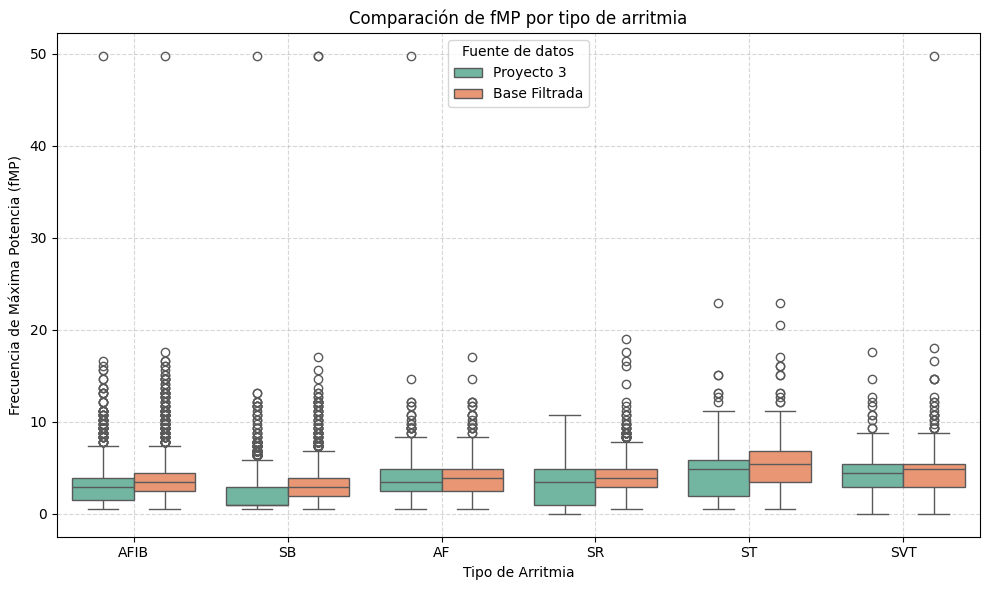

In [ ]:
# Agregar una columna que identifique la fuente de los datos
df_proyecto3['Fuente'] = 'Proyecto 3'
df_filtrada['Fuente'] = 'Base Filtrada'

# Unir las dos bases de datos
df_combinada = pd.concat([df_proyecto3, df_filtrada], ignore_index=True)

# Crear el boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Arritmia', y='fMP', hue='Fuente', data=df_combinada, palette='Set2')

plt.title('Comparación de fMP por tipo de arritmia')
plt.ylabel('Frecuencia de Máxima Potencia (fMP)')
plt.xlabel('Tipo de Arritmia')
plt.legend(title='Fuente de datos')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**Normalidad:**

Prueba de Kolmogorov-Smirnov

**Hipótesis:**

p > alpha

*   H0: Los datos parecen normales (No se puede rechazar H0)
*   H1: Los datos no parecen normales (Se rechaza H0)

In [ ]:
from scipy.stats import kstest, zscore

arritmias = df_proyecto3['Arritmia'].unique()

print('Proyecto 3:')
for arritmia in arritmias:
    datos_arritmia = df_proyecto3[df_proyecto3['Arritmia'] == arritmia]['fMP']
    
    # Normalizar los datos con zscore 
    datos_z = zscore(datos_arritmia)

    ks_stats2, p_value2 = kstest(datos_z, 'norm')
    
    print(f'\nArritmia: {arritmia}')
    print('Estadístico KS = %.3f, p-valor = %.3f' % (ks_stats2, p_value2))

    if p_value2 > 0.05:
        print('Los datos parecen normales (No se puede rechazar H0)')
    else:
        print('Los datos no parecen normales (Se rechaza H0)')

Proyecto 3:

Arritmia: AFIB
Estadístico KS = 0.165, p-valor = 0.000
Los datos no parecen normales (Se rechaza H0)

Arritmia: SB
Estadístico KS = 0.316, p-valor = 0.000
Los datos no parecen normales (Se rechaza H0)

Arritmia: AF
Estadístico KS = 0.191, p-valor = 0.000
Los datos no parecen normales (Se rechaza H0)

Arritmia: SR
Estadístico KS = 0.128, p-valor = 0.000
Los datos no parecen normales (Se rechaza H0)

Arritmia: ST
Estadístico KS = 0.122, p-valor = 0.000
Los datos no parecen normales (Se rechaza H0)

Arritmia: SVT
Estadístico KS = 0.109, p-valor = 0.000
Los datos no parecen normales (Se rechaza H0)


In [ ]:
from scipy.stats import kstest, zscore

arritmias = df_filtrada['Arritmia'].unique()

print('Proyectos anteriores:')
for arritmia in arritmias:
    datos_arritmia = df_filtrada[df_filtrada['Arritmia'] == arritmia]['fMP']
    
    # Normalizar los datos con zscore 
    datos_z = zscore(datos_arritmia)

    ks_stats2, p_value2 = kstest(datos_z, 'norm')
    
    print(f'\nArritmia: {arritmia}')
    print('Estadístico KS = %.3f, p-valor = %.3f' % (ks_stats2, p_value2))

    if p_value2 > 0.05:
        print('Los datos parecen normales (No se puede rechazar H0)')
    else:
        print('Los datos no parecen normales (Se rechaza H0)')

Proyecto 3:

Arritmia: AFIB
Estadístico KS = 0.207, p-valor = 0.000
Los datos no parecen normales (Se rechaza H0)

Arritmia: SB
Estadístico KS = 0.231, p-valor = 0.000
Los datos no parecen normales (Se rechaza H0)

Arritmia: AF
Estadístico KS = 0.169, p-valor = 0.000
Los datos no parecen normales (Se rechaza H0)

Arritmia: SR
Estadístico KS = 0.172, p-valor = 0.000
Los datos no parecen normales (Se rechaza H0)

Arritmia: ST
Estadístico KS = 0.119, p-valor = 0.000
Los datos no parecen normales (Se rechaza H0)

Arritmia: SVT
Estadístico KS = 0.211, p-valor = 0.000
Los datos no parecen normales (Se rechaza H0)


### **Kruskal-Wallis por tipo de arritmia**

**Base de datos PROYECTO 3**

Kruskal-Wallis en Proyecto 3:
Estadístico H: 1581.3903, p-valor: 0.0000

Hay diferencias significativas entre arritmias.

Comparaciones con la prueba de Dunn:
                AF          AFIB             SB             SR             ST  \
AF    1.000000e+00  6.355304e-10   1.535272e-53   2.159344e-01   1.668528e-07   
AFIB  6.355304e-10  1.000000e+00   5.863851e-52   3.138930e-09   3.630528e-73   
SB    1.535272e-53  5.863851e-52   1.000000e+00  1.056406e-103  1.614569e-249   
SR    2.159344e-01  3.138930e-09  1.056406e-103   1.000000e+00   3.014295e-31   
ST    1.668528e-07  3.630528e-73  1.614569e-249   3.014295e-31   1.000000e+00   
SVT   1.109357e-03  5.216538e-32  1.248055e-103   5.254091e-13   1.000000e+00   

                SVT  
AF     1.109357e-03  
AFIB   5.216538e-32  
SB    1.248055e-103  
SR     5.254091e-13  
ST     1.000000e+00  
SVT    1.000000e+00  


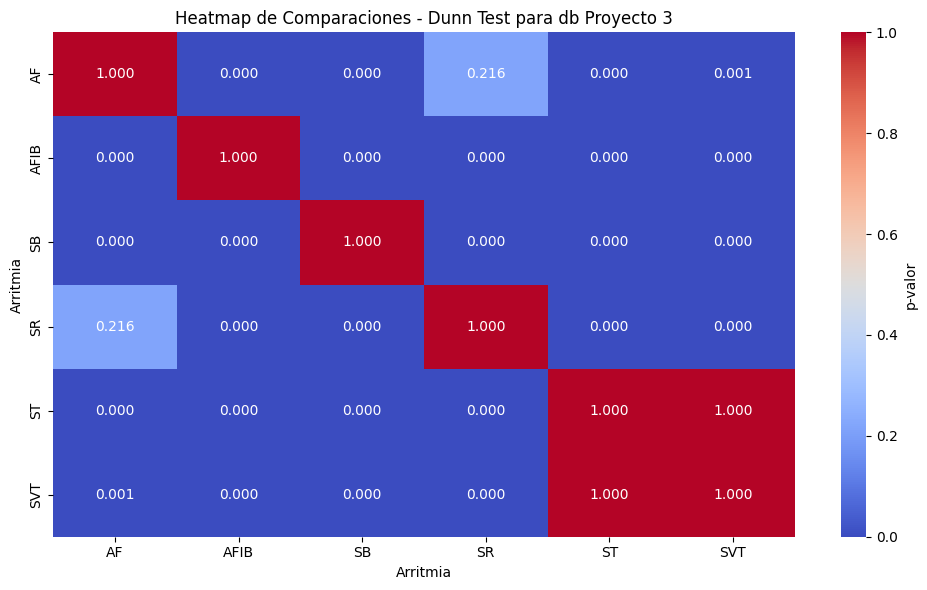

In [29]:
from scipy.stats import kruskal
import scikit_posthocs as sp

# Filtrar las arritmias de df_proyecto3
arritmias_proy3 = df_proyecto3['Arritmia'].unique()

# Preparar las muestras por arritmia
grupos_proy3 = [df_proyecto3[df_proyecto3['Arritmia'] == arritmia]['fMP'] for arritmia in arritmias_proy3]

# Aplicar Kruskal-Wallis
stat, p_value = kruskal(*grupos_proy3)

print('Kruskal-Wallis en Proyecto 3:')
print(f'Estadístico H: {stat:.4f}, p-valor: {p_value:.4f}')

if p_value < 0.05:
    print("\nHay diferencias significativas entre arritmias.")
    
    # Prueba post-hoc de Dunn
    dunn = sp.posthoc_dunn(df_proyecto3, val_col='fMP', group_col='Arritmia', p_adjust='bonferroni')
    
    print("\nComparaciones con la prueba de Dunn:")
    print(dunn)

    # Heatmap de resultados post-hoc
    plt.figure(figsize=(10, 6))
    sns.heatmap(dunn, annot=True, cmap="coolwarm", fmt=".3f", cbar_kws={'label': 'p-valor'})
    plt.title('Heatmap de Comparaciones - Dunn Test para db Proyecto 3')
    plt.xlabel('Arritmia')
    plt.ylabel('Arritmia')
    plt.tight_layout()
    plt.show()

else:
    print("\nNo hay diferencias significativas entre arritmias.")


**Base de datos ECG filtrada**


Kruskal-Wallis en Base Filtrada:
Estadístico H: 1112.6299, p-valor: 0.0000

Hay diferencias significativas entre arritmias.

Comparaciones con la prueba de Dunn:
                AF          AFIB             SB            SR             ST  \
AF    1.000000e+00  1.363024e-02   1.174205e-19  1.114684e-01   3.064144e-18   
AFIB  1.363024e-02  1.000000e+00   2.734616e-24  1.363493e-19   4.162862e-75   
SB    1.174205e-19  2.734616e-24   1.000000e+00  2.087090e-92  4.349759e-194   
SR    1.114684e-01  1.363493e-19   2.087090e-92  1.000000e+00   9.961763e-20   
ST    3.064144e-18  4.162862e-75  4.349759e-194  9.961763e-20   1.000000e+00   
SVT   1.092037e-01  6.359231e-11   3.134098e-40  1.000000e+00   2.110641e-08   

               SVT  
AF    1.092037e-01  
AFIB  6.359231e-11  
SB    3.134098e-40  
SR    1.000000e+00  
ST    2.110641e-08  
SVT   1.000000e+00  


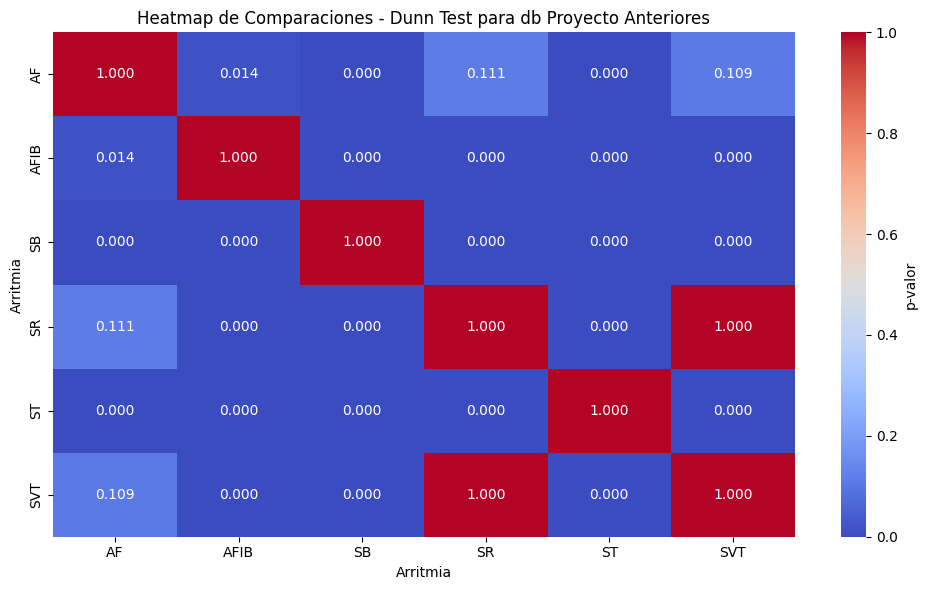

In [30]:
# Filtrar las arritmias de df_filtrada
arritmias_filtrada = df_filtrada['Arritmia'].unique()

# Preparar las muestras por arritmia
grupos_filtrada = [df_filtrada[df_filtrada['Arritmia'] == arritmia]['fMP'] for arritmia in arritmias_filtrada]

# Aplicar Kruskal-Wallis
stat, p_value = kruskal(*grupos_filtrada)

print('\nKruskal-Wallis en Base Filtrada:')
print(f'Estadístico H: {stat:.4f}, p-valor: {p_value:.4f}')

if p_value < 0.05:
    print("\nHay diferencias significativas entre arritmias.")
    
    # Prueba post-hoc de Dunn
    dunn = sp.posthoc_dunn(df_filtrada, val_col='fMP', group_col='Arritmia', p_adjust='bonferroni')
    
    print("\nComparaciones con la prueba de Dunn:")
    print(dunn)

    # Heatmap de resultados post-hoc
    plt.figure(figsize=(10, 6))
    sns.heatmap(dunn, annot=True, cmap="coolwarm", fmt=".3f", cbar_kws={'label': 'p-valor'})
    plt.title('Heatmap de Comparaciones - Dunn Test para db Proyecto Anteriores')
    plt.xlabel('Arritmia')
    plt.ylabel('Arritmia')
    plt.tight_layout()
    plt.show()

else:
    print("\nNo hay diferencias significativas entre arritmias.")